# **Part 3**

EE267 

Student: Rojin Zandi

Importing Packages

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as Layers
from tensorflow.keras.utils import plot_model
import tensorflow.keras.activations as Actications
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm
import os
import pathlib
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from random import randint
from IPython.display import SVG
import seaborn as sns
import matplotlib.gridspec as gridspec
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
cd 'drive' 

/content/drive


In [ ]:
cd 'My Drive/Intel_Dataset'

/content/drive/My Drive/Intel_Dataset


In [ ]:
!ls

model.png  seg_pred  seg_test  seg_train  traininghistory.pdf


In [ ]:
%pwd

'/content/drive/My Drive/Intel_Dataset'

In [ ]:
train_dir = pathlib.Path('./seg_train/seg_train')

train_image_count = len(list(train_dir.glob('*/*.jpg')))
print("Number of images in training set:",train_image_count)

Number of images in training set: 14034


In [ ]:
test_dir = pathlib.Path('./seg_test/seg_test')

test_image_count = len(list(test_dir.glob('*/*.jpg')))
print("Number of images in test set:",test_image_count)

Number of images in test set: 3000


In [ ]:
Labels = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
print("Number of Labels in Intel dataset:",Labels.shape)

Number of Labels in Intel dataset: (6,)


# Preprocessing

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['./seg_train/seg_train', './seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  0%|          | 0/2191 [00:00<?, ?it/s]

Loading ./seg_train/seg_train


  0%|          | 0/510 [00:00<?, ?it/s]

Loading ./seg_test/seg_test


100%|██████████| 501/501 [02:20<00:00,  3.55it/s]


In [ ]:
#@title Default title text
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


Bar plot of the number of images in each class of the training and test set

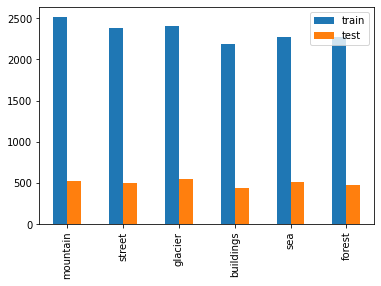

In [ ]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

Pie chart of the proportion of each observed category in the training set

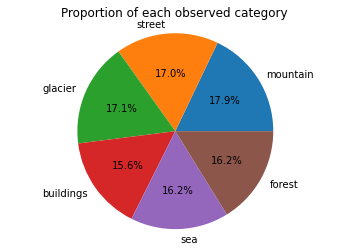

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

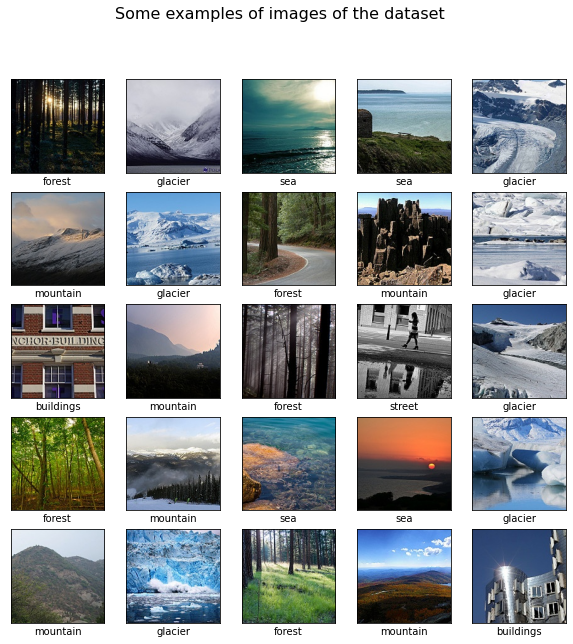

In [ ]:
display_examples(class_names, train_images, train_labels)

# CNN Model

In [ ]:
from keras.applications.resnet50 import ResNet50
# load model
model = keras.applications.resnet50.ResNet50(weights="imagenet")
# summarize the model
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=100, epochs=5, validation_split = 0.3)

Epoch 1/5
99/99 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9454 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f35e918a378> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
99/99 [==============================] - 3823s 39s/step - loss: 0.1571 -

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

94/94 - 211s - loss: 1.7106 - accuracy: 0.5713

Test accuracy: 0.5713333487510681


The model is overfitting, but unfortunately I did not have enough time to decrease overfitting.